# Simulation of Complex Systems - Chapter 6
Artur Gasparyan

## Exercise 6.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import constants

In [2]:
rng = np.random.default_rng()
time_res = 1
n_steps = 10000
n_simulations = 100
time_step = 0.0001

k_boltz = constants.Boltzmann / (10E-6**2) 
temperature = 300
gamma = 1.4
tau = 3E-4
k_stiff = 300

In [3]:
def calculate_trajectories_overdamped(n_simulations, n_steps, time_step):
    trajectories = np.zeros((n_simulations, n_steps, 2))
    fluctations = rng.normal(size=(n_simulations, n_steps, 2))/math.sqrt(2)   # Random 2D steps scaled to length w_i
    factor = math.sqrt(2*k_boltz*temperature*time_step/gamma)
    scaled_fluctuations = fluctations * factor
    
    for i in range(1, n_steps):
        trajectories[:, i, :] = trajectories[:, i-1, :] + scaled_fluctuations[:, i, :]
        
    return trajectories


x_overdamped = calculate_trajectories_overdamped(n_simulations, n_steps, time_step)
x_overdamped_long = calculate_trajectories_overdamped(1, n_steps*time_res, time_step/time_res).reshape(-1, 2)

In [4]:
def calculate_trajectories_inertial(n_simulations, n_steps, time_step):
    trajectories = np.zeros((n_simulations, n_steps, 2))
    fluctations = rng.normal(size=(n_simulations, n_steps, 2))/math.sqrt(2)   # Random 2D steps normalized to 1
    
    factor_1 = (2+time_step*tau) / (1+time_step*tau)
    factor_2 = -1/(1 + time_step * tau)
    factor_3 = math.sqrt(2*k_boltz*temperature*gamma) / (tau*gamma*(1+time_step*tau)) * time_step**1.5
                        
    scaled_fluctuations = fluctations * factor_3

        
    for i in range(1, n_steps):
        trajectories[:, i, :] = (
            factor_1 * trajectories[:, i-1, :] +
            factor_2 * trajectories[:, i-2, :] +
            scaled_fluctuations[:, i, :]
        )
    
    return trajectories


x_inertial = calculate_trajectories_inertial(n_simulations, n_steps, time_step)
x_inertial_long = calculate_trajectories_inertial(1, n_steps*time_res, time_step/time_res).reshape(-1, 2)

In [5]:
def calculate_trajectories_trapped(n_simulations, n_steps, time_step):
    trajectories = np.zeros((n_simulations, n_steps, 2))
    fluctations = rng.normal(size=(n_simulations, n_steps, 2))/math.sqrt(2)   # Random 2D steps normalized to 1
    
    factor_1 = 1 - k_stiff/gamma*time_step
    factor_2 = math.sqrt(2*k_boltz*temperature*time_step/gamma)
    
    scaled_fluctuations = fluctations * factor_2
    
    for i in range(1, n_steps):
        trajectories[:, i, :] = factor_1 * trajectories[:, i-1, :] + scaled_fluctuations[:, i, :]
        
    return trajectories

x_trapped = calculate_trajectories_trapped(n_simulations, n_steps, time_step)
x_trapped_long = calculate_trajectories_trapped(1, n_steps*time_res, time_step/time_res).reshape(-1, 2)

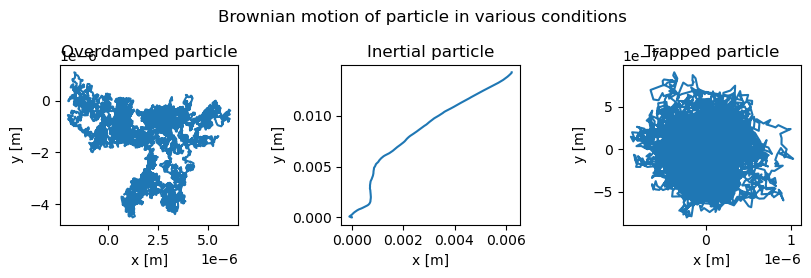

In [6]:
x_all = [x_overdamped, x_inertial, x_trapped]

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
fig.tight_layout(pad=4)
fig.suptitle("Brownian motion of particle in various conditions")
titles = ["Overdamped particle", "Inertial particle", "Trapped particle"]

for x, ax, title in zip(x_all, axes, titles):
    ax.plot(x[0, :, 0], x[0, :, 1])
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_title(title)


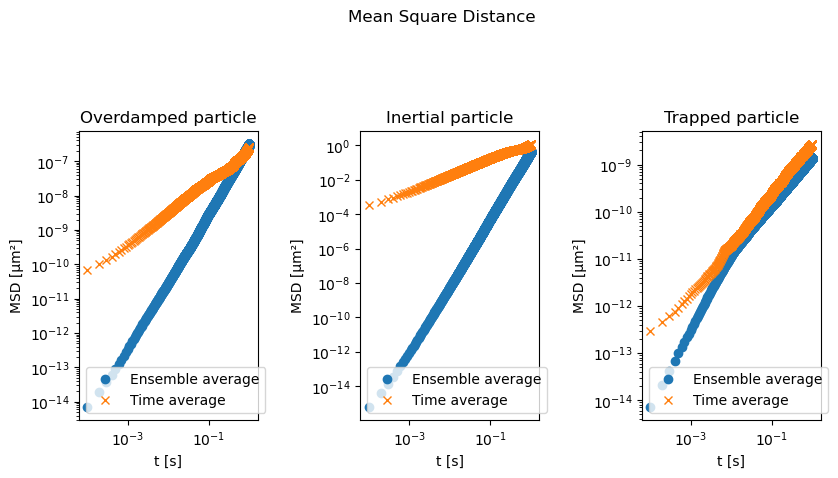

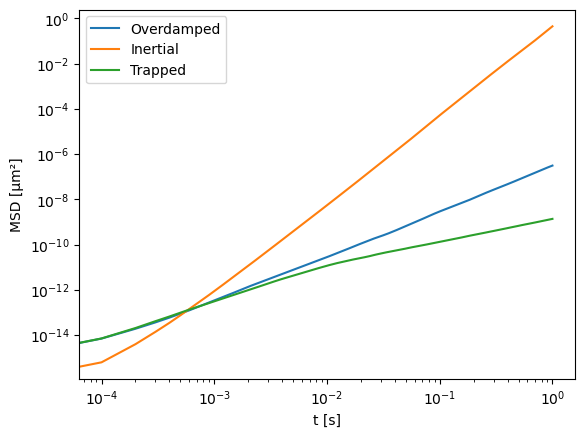

In [7]:
def get_metrics_from_x(x, x_long, n_steps, time_step, time_res):
    sqr_dist = np.linalg.norm(x, axis=2)**2  # x0 is always (0, 0)
    msd = np.cumsum(sqr_dist, axis=1)
    #msd = sqr_dist
    emsd = np.mean(msd, axis=0)
    
    # https://physics.stackexchange.com/a/438200
    # OBSERVE: DOES NOT WORK
    tmsd = np.zeros(n_steps)    
    for i in range(n_steps):
        #msd_sum = 0
        #offset = i*time_res
        #for j in range(time_res):
        #    msd_sum += (np.linalg.norm(x_long[offset] - x_long[offset+j]))**2
        #    
        #tmsd[i] = tmsd[i-1] + msd_sum / time_res
            
        #x_interval = x_long[(i)*time_res:(i+1)*time_res]
        x_curr = x_long[i*time_res]
        displacement = x_long-x_curr
        #sqr_dist_t = np.sum(displacement[:, 0]**2-displacement[:, 1]**2)
        sqr_dist_t = np.linalg.norm(displacement, axis=1)**2
        
        tmsd[i] = tmsd[i-1] + np.mean(sqr_dist_t)
        #tmsd[i] = tmsd[i-1] + (sqr_dist_t) / n_steps

        #tmsd[i] = np.mean(sqr_dist_t)
                        
    return {"sqr_dist": sqr_dist, "msd": msd, "emsd": emsd, "tmsd": tmsd}

metrics_overdamped = get_metrics_from_x(x_overdamped, x_overdamped_long, n_steps, time_step, time_res)
metrics_inertial = get_metrics_from_x(x_inertial, x_inertial_long, n_steps, time_step, time_res)
metrics_trapped = get_metrics_from_x(x_trapped, x_trapped_long, n_steps, time_step, time_res)
metrics_all = [metrics_overdamped, metrics_inertial, metrics_trapped]
titles = ["Overdamped particle", "Inertial particle", "Trapped particle"]

fig, axes = plt.subplots(1, 3, figsize=(9, 5))
fig.suptitle("Mean Square Distance")
fig.tight_layout(pad=4)

t = np.arange(n_steps)*time_step
for metric, ax, title in zip(metrics_all, axes, titles):
    ax.plot(t, metric["emsd"], 'o')
    ax.plot(t, metric["tmsd"], 'x')  # TODO: FIX THIS
    ax.set_title(title)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel("t [s]")
    ax.set_ylabel("MSD [µm²]")
    ax.legend(["Ensemble average", "Time average"])

    
fig = plt.figure()
plt.plot(t, metrics_overdamped["emsd"])
plt.plot(t, metrics_inertial["emsd"])
plt.plot(t, metrics_trapped["emsd"])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('t [s]')
plt.ylabel('MSD [µm²]')
plt.legend(["Overdamped", "Inertial", "Trapped"]);

## Exercise 6.2